In [14]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from Utils.Optuna import optuna_hyperparameter_tuning
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
from catboost import CatBoostRegressor
import numpy as np
from pipeline import Pipeline

In [24]:
data = pd.read_csv("Data/cleaned_data.csv")
columns = pd.read_json("Data/selected_features_15.json")[0]

In [29]:
pipeline = Pipeline(data, CatBoostRegressor)
data_preprocessed = pipeline.data_preprocessing(data)
X = data_preprocessed[columns]
y = data_preprocessed['CREDIT_SCORE']
X.shape

2024-03-16 13:53:32.242 | INFO     | pipeline:data_preprocessing:19 - Data Preprocessing
2024-03-16 13:53:32.244 | INFO     | preprocessing.check_nans:transform:14 - CheckNans is starting
2024-03-16 13:53:32.245 | INFO     | preprocessing.check_nans:transform:17 - No NaNs in dataframe
2024-03-16 13:53:32.246 | INFO     | preprocessing.minmax_scaler:fit:16 - _MinMaxScaler preprocessing class_ is fitting
2024-03-16 13:53:32.248 | INFO     | preprocessing.minmax_scaler:fit:19 - _MinMaxScaler preprocessing class_ fitting ended
2024-03-16 13:53:32.249 | INFO     | preprocessing.minmax_scaler:transform:38 - _MinMaxScaler preprocessing class_ is starting transformation
2024-03-16 13:53:32.253 | INFO     | preprocessing.minmax_scaler:transform:41 - _MinMaxScaler preprocessing class_ transformation ended
2024-03-16 13:53:32.331 | INFO     | preprocessing.check_and_remove_outliers:transform:31 - Number of outliers in dataframe: 22
2024-03-16 13:53:32.332 | INFO     | pipeline:data_preprocessing:

(878, 37)

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_eval.shape, y_eval.shape

((631, 37), (631,), (176, 37), (176,), (71, 37), (71,))

In [5]:
def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_loguniform("learning_rate", 0.001, 1)
    param['depth'] = trial.suggest_int('depth', 3, 15)
    param['l2_leaf_reg'] = trial.suggest_loguniform('l2_leaf_reg', 0.01, 10)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['grow_policy'] = 'Depthwise'
    param['iterations'] = trial.suggest_int('iterations', 100, 1000)
    param['use_best_model'] = True
    param['eval_metric'] = 'RMSE'
    param['od_type'] = 'iter'
    param['od_wait'] = 20
    param['logging_level'] = 'Silent'
    
    regressor = CatBoostRegressor(**param)

    regressor.fit(X_train.copy(), y_train.copy(),
                  eval_set=[(X_eval.copy(), y_eval.copy())],
                  early_stopping_rounds=10)
    loss = mean_squared_error(y_valid, regressor.predict(X_valid.copy()))
    return loss


In [6]:
%%time
study = optuna.create_study(study_name=f'catboost-seed{42}')
study.optimize(objective, n_trials=5000, n_jobs=-1, timeout=2400)

[I 2024-03-15 15:15:15,089] A new study created in memory with name: catboost-seed42
C:\Users\user\AppData\Local\Temp\ipykernel_16088\1974728125.py:3: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001)
C:\Users\user\AppData\Local\Temp\ipykernel_16088\1974728125.py:5: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
[I 2024-03-15 15:15:16,946] Trial 6 finished with value: 3767.801531023317 and parameters: {'learning_rate': 0.012, 'depth': 11, 'l2_leaf_reg': 5.0, 'min_child_samples': 32}. Best 

KeyboardInterrupt: 

In [14]:
study.best_value

3452.233121266844

In [15]:
study.best_params


{'learning_rate': 0.02,
 'depth': 13,
 'l2_leaf_reg': 4.0,
 'min_child_samples': 32}

In [ ]:
{
    'learning_rate': 0.017,
    'depth': 13,
    'l2_leaf_reg': 2.5,
    'min_child_samples': 32
}

In [31]:
%%time
optimized_regressor = CatBoostRegressor(learning_rate=0.017,
                                        depth=13,
                                        l2_leaf_reg=2.5,
                                        min_child_samples=32,
                                        grow_policy='Depthwise',
                                        iterations=10000,
                                        use_best_model=True,
                                        eval_metric='RMSE',
                                        od_type='iter',
                                        od_wait=20,
                                        random_state=42,
                                        logging_level='Silent',
                                        task_type='GPU')
optimized_regressor.fit(X_train.copy(), y_train.copy(),
                        eval_set=[(X_eval.copy(), y_eval.copy())],
                        plot=True,
                        early_stopping_rounds=10)
pred_train = optimized_regressor.predict(X_train.copy())
pred_valid = optimized_regressor.predict(X_valid.copy())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 5.62 s, sys: 491 ms, total: 6.11 s
Wall time: 846 ms


In [32]:
optimized_regressor.tree_count_

256

In [33]:
optimized_regressor.get_best_iteration()

255

In [34]:
print("Training set metrics:")
print(mean_squared_error(y_train, pred_train))
print(r2_score(y_train, pred_train))
print(mean_absolute_error(y_train, pred_train))
print(np.sqrt(mean_squared_error(y_train, pred_train)))

print("Validation set metrics:")
print(mean_squared_error(y_valid, pred_valid))
print(r2_score(y_valid, pred_valid))
print(mean_absolute_error(y_valid, pred_valid))
print(np.sqrt(mean_squared_error(y_valid, pred_valid)))


Training set metrics:
0.0010592339625518244
0.9329096693766021
0.024632527915917704
0.03254587473938632
Validation set metrics:
0.004049954883068377
0.7761880761113633
0.04441060919355982
0.06363925583370988


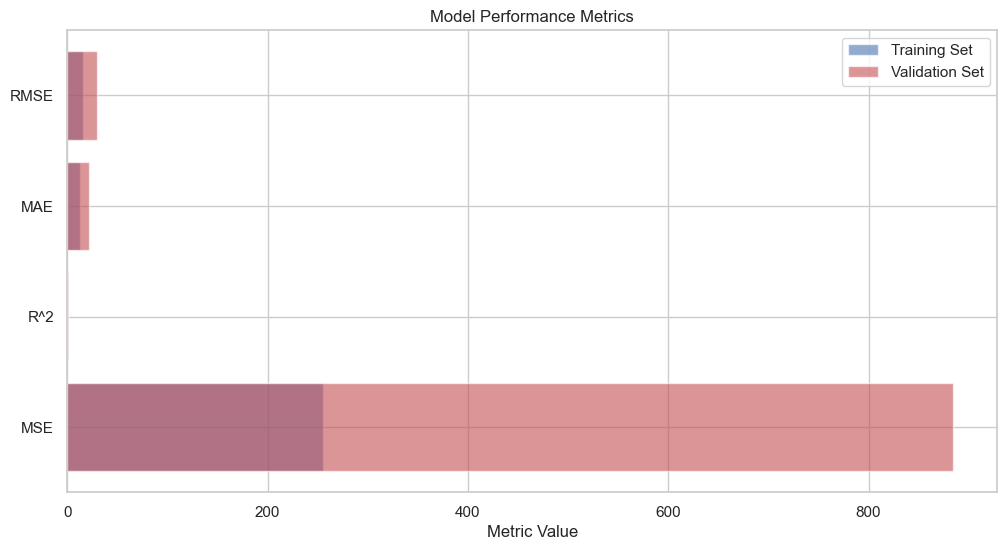

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to plot the metrics
def plot_metrics(y_true_train, y_pred_train, y_true_valid, y_pred_valid):
    # Metrics calculation
    mse_train = mean_squared_error(y_true_train, y_pred_train)
    r2_train = r2_score(y_true_train, y_pred_train)
    mae_train = mean_absolute_error(y_true_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)

    mse_valid = mean_squared_error(y_true_valid, y_pred_valid)
    r2_valid = r2_score(y_true_valid, y_pred_valid)
    mae_valid = mean_absolute_error(y_true_valid, y_pred_valid)
    rmse_valid = np.sqrt(mse_valid)

    # Plotting
    metrics = ['MSE', 'R^2', 'MAE', 'RMSE']
    train_values = [mse_train, r2_train, mae_train, rmse_train]
    valid_values = [mse_valid, r2_valid, mae_valid, rmse_valid]

    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")
    plt.barh(metrics, train_values, color='b', alpha=0.6, label='Training Set')
    plt.barh(metrics, valid_values, color='r', alpha=0.6, label='Validation Set')

    plt.xlabel('Metric Value')
    plt.title('Model Performance Metrics')
    plt.legend()
    plt.show()

# Call the function with your prediction results
plot_metrics(y_train, pred_train, y_valid, pred_valid)


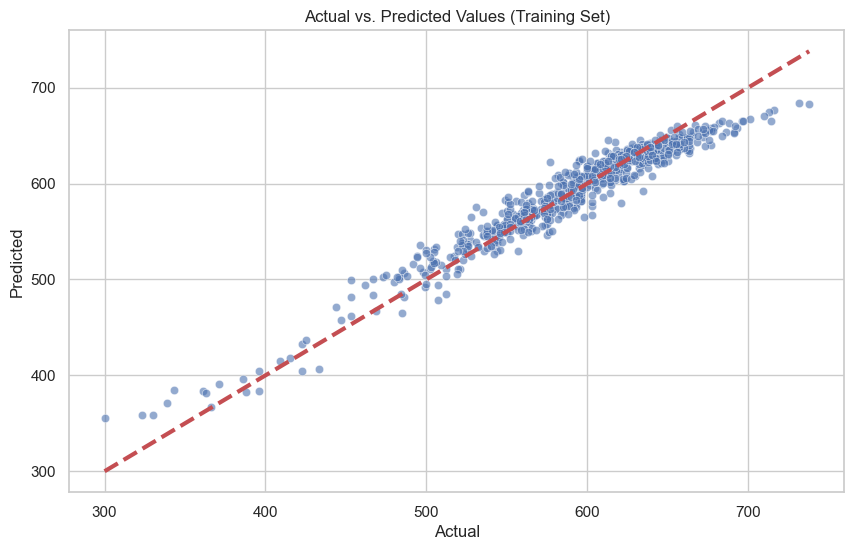

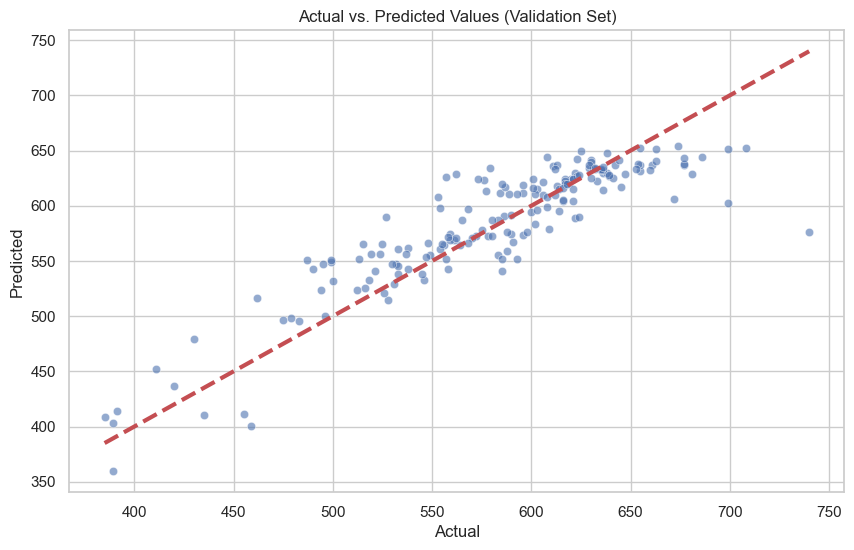

In [10]:
def plot_actual_vs_predicted(y_true, y_pred, dataset_type='Training'):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=3) # Diagonal line
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs. Predicted Values ({dataset_type} Set)')
    plt.show()

plot_actual_vs_predicted(y_train, pred_train, 'Training')
plot_actual_vs_predicted(y_valid, pred_valid, 'Validation')


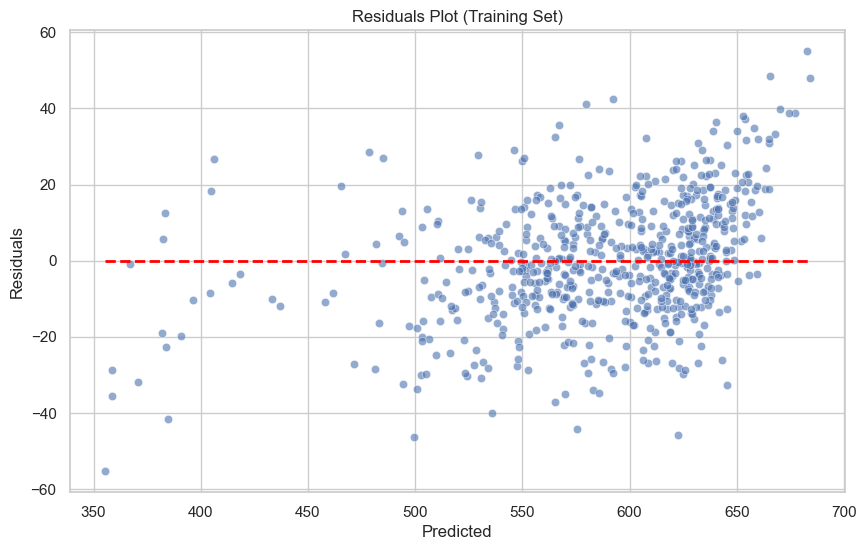

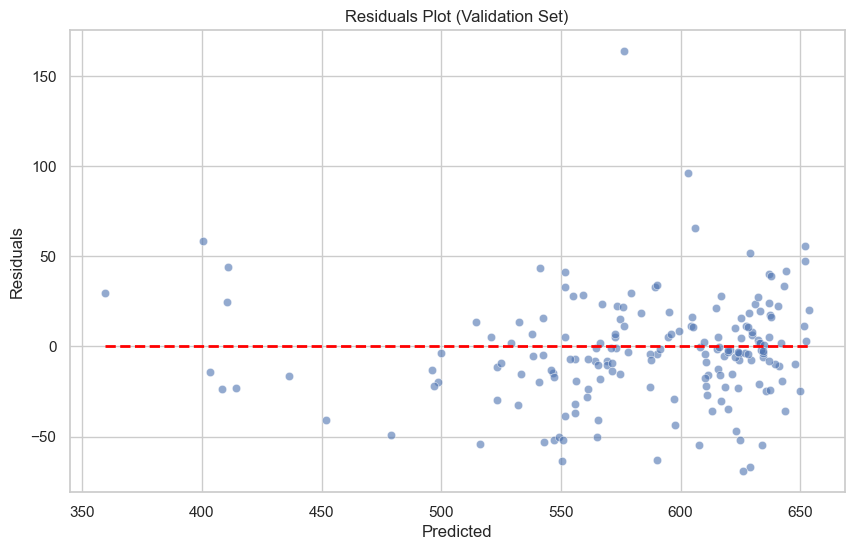

In [11]:
def plot_residuals(y_true, y_pred, dataset_type='Training'):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='--', lw=2)
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title(f'Residuals Plot ({dataset_type} Set)')
    plt.show()

plot_residuals(y_train, pred_train, 'Training')
plot_residuals(y_valid, pred_valid, 'Validation')
